### Importing libraries


In [10]:
# importing libraries
import pandas as pd 
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### loading the dataset

In [3]:
train_set=pd.read_csv('/content/drive/MyDrive/ArabicSentimentHager/paper1/TF-IDF/dataset2/train_datasetset2.csv',encoding='utf-8')
test_set=pd.read_csv("/content/drive/MyDrive/ArabicSentimentHager/paper1/TF-IDF/dataset2/unseen_dataset2.csv")
train_set.head()

,label,text
0,1,اترك تهوى لاجل تخشى
1,1,عمرتنا مميزة ورائعة
2,1,﻿قصه غايه الروعة
3,1,﻿اللهم اجعلنا دائما مسلمين صادقين افكارنا اعمالنا
4,0,والله تحشيش الاخر


In [8]:
X_train=train_set.drop(columns =['label'], axis = 1)
y_train=train_set['label']
X_train.shape, y_train.shape

((1560, 1), (1560,))

In [9]:
y_test=test_set['label']
X_test=test_set.drop(columns =['label'], axis = 1)
X_test.shape, y_test.shape

((391, 1), (391,))

### LabelEncoder

In [6]:
encoder_y = LabelEncoder()
y_train= encoder_y.fit_transform(y_train)
y_test = encoder_y.transform(y_test)

### TF-IDF feature extraction method

In [11]:
tfidf_vect = TfidfVectorizer(max_features=5000 , ngram_range=(1,1))
tfidf_train = tfidf_vect.fit_transform(X_train['text'])
tfidf_test = tfidf_vect.transform(X_test['text'])

### Finding best model and hyper parameters

In [12]:
model_params = {
    
    'RF': {
        'model': RandomForestClassifier(),
        'params' :   { 'max_depth': [100,200],
        'criterion': ['gini', 'entropy'],
        }
    },
    'LR' : {
        'model': LogisticRegression(solver='sag'),
        'params': { "C":np.logspace(-3,3,7), "penalty":['none', 'l1', 'l2', 'elasticnet'],
              "solver" : ['newton-cg','lbfgs','liblinear','sag','saga'],
    'class_weight':['balanced', None]
             }}
    ,
    'DT': {
        'model': DecisionTreeClassifier(),
        'params': {'max_depth':[100,200],
                
             'max_features': [1, 2, 3, 4,5,6,7,8,9,10],
             'criterion': ['gini', 'entropy'],
             
        }
    }  
    ,
    'NB': {
        'model':  MultinomialNB(),
        'params': {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  }
    } ,
     'KNN': {
     'model': KNeighborsClassifier(),
    'params':  {'n_neighbors':[50,60,70,100],'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}
    }


}

In [13]:
scores = []
model={}
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=10, scoring = 'accuracy',return_train_score=False)
    clf.fit(tfidf_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_grid=clf.fit(tfidf_train, y_train)
    model[model_name]=best_grid.best_estimator_
df = pd.DataFrame(scores,columns=['model','best_params'])


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

### Print best values of parameters for each model

In [14]:
df

,model,best_params
0,RF,"{'criterion': 'entropy', 'max_depth': 100}"
1,LR,"{'C': 100.0, 'class_weight': None, 'penalty': ..."
2,DT,"{'criterion': 'gini', 'max_depth': 200, 'max_f..."
3,NB,{'alpha': 0.1}
4,KNN,"{'algorithm': 'auto', 'n_neighbors': 50, 'weig..."


### Geting cross-validation result for cross-validation and testing result for unseen set

In [15]:
scoring=['accuracy','roc_auc','recall','f1','precision']

In [16]:
best_model={'RF':model['RF'],'LR':model['LR'],'DT':model['DT'],
            'NB':model['NB'],'KNN':model['KNN']}

In [20]:
finaltrain = pd.DataFrame([])
ReultofTest=pd.DataFrame([])
for model_name, i in best_model.items():   
    Model=i
    AccuracyTrain=[]
    PrecisionTrain=[]
    RecallTrain=[]
    F1Train=[]

    AccuracyTest=[]
    PrecisionTest=[]
    RecallTest=[]
    F1Test=[]

    for i in range(0,1):
        if i==0:
            r=70
        elif i== 1:
            r=80
   

        SFold = StratifiedKFold(n_splits=10,  shuffle=True,random_state=r)
        Train_Score = cross_validate(Model, tfidf_train, y_train, scoring=scoring,  cv=SFold)
        AccuracyTrain.append(round(100*np.mean(Train_Score['test_accuracy']), 2))
        PrecisionTrain.append(round(100*np.mean(Train_Score['test_precision']), 2))
        RecallTrain.append(round(100*np.mean(Train_Score['test_recall']), 2))
        F1Train.append(round(100*np.mean(Train_Score['test_f1']), 2))
        
        y_pred = cross_val_predict(Model, tfidf_test, y_test, cv=SFold )
        Accurcy_Test= accuracy_score(y_test,y_pred)
        Precision_Test=precision_score(y_test, y_pred, average='weighted')
        Recall_Test=recall_score(y_test, y_pred, average='weighted')
        F1_Test=f1_score(y_test, y_pred, average='weighted') 
        RocTest=roc_auc_score(y_test, y_pred, average='weighted')
        AccuracyTest.append(round(100*Accurcy_Test, 2))
        PrecisionTest.append(round(100*Precision_Test, 2))
        RecallTest.append(round(100*Recall_Test, 2))
        F1Test.append(round(100*F1_Test, 2)) 
 
        finaltrain = finaltrain.append({ 'model':model_name,
                                        'AccuracyTrain' : round(np.mean(AccuracyTrain),2),
                                        'PrecisionTrain':round(np.mean(PrecisionTrain),2),
                                        'RecallTrain':round(np.mean(RecallTrain),2),  
                                        'F1Train':round(np.mean(F1Train),2),
                                        
                                       } , ignore_index=True)
        finaltrain.reindex(['model','AccuracyTrain','PrecisionTrain','RecallTrain','F1Train'], axis=1)
        
       
        ReultofTest=ReultofTest.append({'model':model_name,
                                        'AccuracyTest' : round(np.mean(AccuracyTest),2),
                                        'PrecisionTest':round(np.mean(PrecisionTest),2),
                                        'RecallTest' : round(np.mean(RecallTest),2),'F1Test':round(np.mean(F1Test),2),
                                       
                                       }, ignore_index=True)
        ReultofTest.reindex(['model','AccuracyTest','PrecisionTest','RecallTest','F1Test'],axis=1)
       

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

### Print avarage of training set and testing set 

In [21]:
with pd.option_context('expand_frame_repr', False):
    print (finaltrain)


  model  AccuracyTrain  PrecisionTrain  RecallTrain  F1Train
0    RF          78.85           88.42        67.25    76.34
1    LR          85.26           88.86        81.24    84.84
2    DT          62.24           68.63        67.67    61.40
3    NB          84.17           80.80        90.69    85.34
4   KNN          77.82           81.35        74.19    77.23


In [22]:
with pd.option_context('expand_frame_repr', False):
    print (ReultofTest)


  model  AccuracyTest  PrecisionTest  RecallTest  F1Test
0    RF         73.66          73.67       73.66   73.66
1    LR         73.66          74.43       73.66   73.51
2    DT         68.54          70.56       68.54   67.90
3    NB         74.42          76.02       74.42   73.94
4   KNN         66.50          68.35       66.50   65.43


### Print ROC curve of models

In [24]:

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for k,v in best_model.items():
   
    #yproba = cls.predict(tfidf_test)
    y_pred = cross_val_predict(v, tfidf_test, y_test, cv=SFold )
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = round(roc_auc_score(y_test, y_pred),5)*100
    
    result_table = result_table.append({'classifiers':k,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc, 
                                        'y_pred': y_pred}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

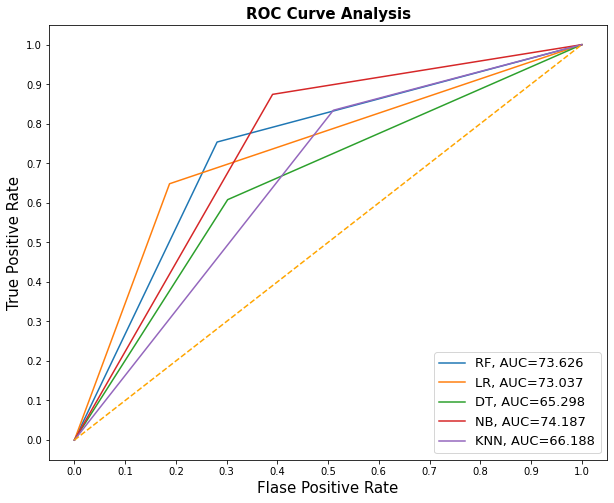

In [25]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()